In [40]:
# %pip install hyperopt

In [41]:
from tqdm import tqdm
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gymnasium as gym
import quantstats as qs
# import gym_anytrading

import sys
sys.path.append("C:/Users/WilliamFetzner/Documents/Trading/gym-anytrading/gym_anytrading")
import importlib
%load_ext autoreload
%autoreload 2
from envs import MyForexEnv, Actions
# sys.path.append("C:/Users/WilliamFetzner/Documents/Trading/gym-anytrading/")
# from datasets import FOREX_EURUSD_RENKO
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.callbacks import BaseCallback
import torch
from hyperopt import hp


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
name = 'FOREX_EURUSD_RENKO'
# base_dir = os.path.dirname(os.path.abspath(__file__))
path = "C:/Users/WilliamFetzner/Documents/Trading/gym-anytrading/gym_anytrading/datasets/data/renko_full_data_50.csv"
# path = os.path.join(base_dir, '.csv')
FOREX_EURUSD_RENKO = pd.read_csv(path, parse_dates=True, index_col='datetime')

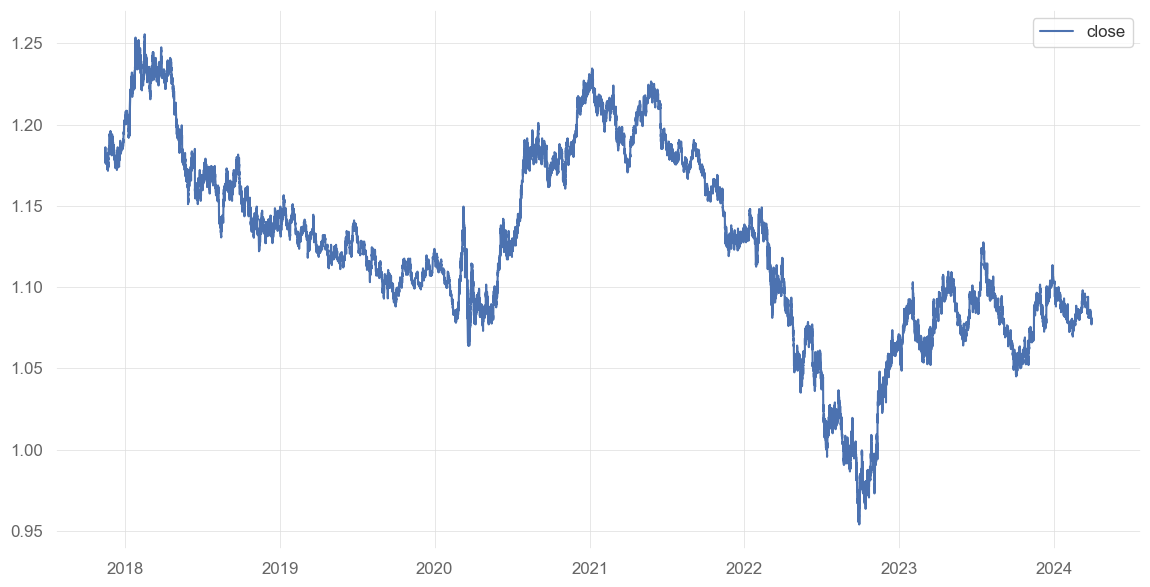

In [43]:
# plot the close price over time
plt.figure(figsize=(14, 7))
plt.plot(FOREX_EURUSD_RENKO.close, label='close')
plt.legend()
plt.show()


In [44]:
def print_stats(reward_over_episodes):
    """  Print Reward  """

    avg = np.mean(reward_over_episodes)
    min = np.min(reward_over_episodes)
    max = np.max(reward_over_episodes)

    print (f'Min. Reward          : {min:>10.3f}')
    print (f'Avg. Reward          : {avg:>10.3f}')
    print (f'Max. Reward          : {max:>10.3f}')

    return min, avg, max


# ProgressBarCallback for model.learn()
class ProgressBarCallback(BaseCallback):

    def __init__(self, check_freq: int, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.progress_bar = tqdm(total=self.model._total_timesteps, desc="model.learn()")

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            self.progress_bar.update(self.check_freq)
        return True
    
    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        self.progress_bar.close()

In [45]:
# # find the max date for FOREX_EURUSD_RENKO
# max_date = FOREX_EURUSD_RENKO.index.max()
# # get the month of the max date
# max_date_month = max_date.month
# second_to_last_month = max_date_month - 1
# # find the row index for the last day of the second to last month
# second_to_last_month_day = FOREX_EURUSD_RENKO[FOREX_EURUSD_RENKO.index.month == second_to_last_month].index.max()
# split = FOREX_EURUSD_RENKO.loc[:second_to_last_month_day].shape[0]

In [46]:
# different split
split = int(len(FOREX_EURUSD_RENKO) * 0.8)
split
# start_index = int(split)
# end_index = int(len(FOREX_EURUSD_RENKO))-((int(len(FOREX_EURUSD_RENKO))-split) % 10)
# print(f'start_index: {start_index} \nend_index: {end_index}')

66988

In [48]:
# env_train = MyForexEnv(
#     df=FOREX_EURUSD_RENKO,
#     window_size=10,
#     frame_bound=(10, int(split)),
#     trade_fee=0.0001,
#     spread=0.0001,
#     spread_bool=False,
#     unit_side='right',
#     sma_length=4,
#     smoothing_sma=4
# )
# print(split)
# new training env based on perplexity suggestion
env_train = MyForexEnv(
    df=FOREX_EURUSD_RENKO,#.iloc[:split, :],
    window_size=10,
    frame_bound=(10, split),
    trade_fee=0.0001,
    spread=0.0001,
    spread_bool=False,
    unit_side='right',
    sma_length=4,
    smoothing_sma=4
)

env_test = MyForexEnv(
    df=FOREX_EURUSD_RENKO,#.iloc[split:, :],
    window_size=10,
    frame_bound=(split, len(FOREX_EURUSD_RENKO)),
    trade_fee=0.0001,
    spread=0.0001,
    spread_bool=False,
    unit_side='right',
    sma_length=4,
    smoothing_sma=4
)


In [49]:
hyperparameters = {
    # it'll be one of these once the other notebook is finished
    'lr': [1e-3, 1e-4, 1e-5], # Learning rate 
    'gamma': [0.9, 0.95, 0.99], # Discount factor
    'ent_coef': [0.01, 0.05, 0.1] # Entropy coefficient
}

In [50]:
space = {
    'lr': hp.loguniform('lr', -5, -2), # Learning rate
    'gamma': hp.uniform('gamma', 0.9, 0.99), # Discount factor
    'ent_coef': hp.loguniform('ent_coef', -5, 0), # Entropy coefficient
    'learning_timesteps': hp.choice('learning_timesteps', [25, 50, 250, 500])
}

In [ ]:
# new train_test_model
def train_test_model(params):
    model = PPO(
        'MlpPolicy',
        env_train,
        verbose=0,
        learning_rate=params['lr'],
        gamma=params['gamma'],
        ent_coef=params['ent_coef']
        # n_steps=128
    )

    model.learn(total_timesteps=params['learning_timesteps'], callback=ProgressBarCallback(100))

    # test the model
    env = env_test
    obs = env.reset()
    done = False
    while not done:
        action, _states = model.predict(obs)
        obs, reward, done, info = env.step(action)

    # print the performance
    qs.extend_pandas()
    result = env.history
    stats = qs.stats(result['total'])
    return -stats['sharpe']

In [ ]:
# seed_ppo = 42  # random seed
# obs_ppo, info_ppo = env_train.reset(seed=seed_ppo)
# torch.manual_seed(seed_ppo)
# random.seed(seed_ppo)
# np.random.seed(seed_ppo)

# vec_env_ppo = None

# model_ppo = PPO(policy_ppo, env_train, verbose=0, lr=hyperparameters['lr'], gamma=hyperparameters['gamma'], ent_coef=hyperparameters['ent_coef'])

# print(f'model {type(model_ppo)}')
# print(f'policy {type(model_ppo.policy)}')

# # custom callback for 'progress_bar'
# model_ppo.learn(total_timesteps=total_learning_timesteps_ppo, callback=ProgressBarCallback(100))

# env_train.close()

model <class 'stable_baselines3.ppo.ppo.PPO'>
policy <class 'stable_baselines3.common.policies.ActorCriticPolicy'>


model.learn(): 5001200it [2:30:45, 552.89it/s]                               


In [54]:
(len(FOREX_EURUSD_RENKO) - split)/10

1674.8

(9, 14) 16715 16725
Iteration 0: Testing Reward = 1365.0155067443848
Iteration 0: Actions = {<Actions.Sell: 0>: 8698, <Actions.Buy: 1>: 8017}
Iteration 0: info = {'total_reward': 1365.0155067443848, 'total_profit': 0.7369958623734704, 'position': <Positions.Long: 1>}
(9, 14) 16715 16725
Iteration 10: Testing Reward = 0.020265579223632812
Iteration 10: Actions = {<Actions.Sell: 0>: 8600, <Actions.Buy: 1>: 8115}
Iteration 10: info = {'total_reward': 0.020265579223632812, 'total_profit': 0.694309121622767, 'position': <Positions.Short: 0>}
(9, 14) 16715 16725
Iteration 20: Testing Reward = 9.883642196655273
Iteration 20: Actions = {<Actions.Sell: 0>: 8577, <Actions.Buy: 1>: 8138}
Iteration 20: info = {'total_reward': 9.883642196655273, 'total_profit': 0.6929225846589169, 'position': <Positions.Long: 1>}
(9, 14) 16715 16725
Iteration 30: Testing Reward = 849.9419689178467
Iteration 30: Actions = {<Actions.Sell: 0>: 7971, <Actions.Buy: 1>: 8744}
Iteration 30: info = {'total_reward': 849.941

KeyboardInterrupt: 

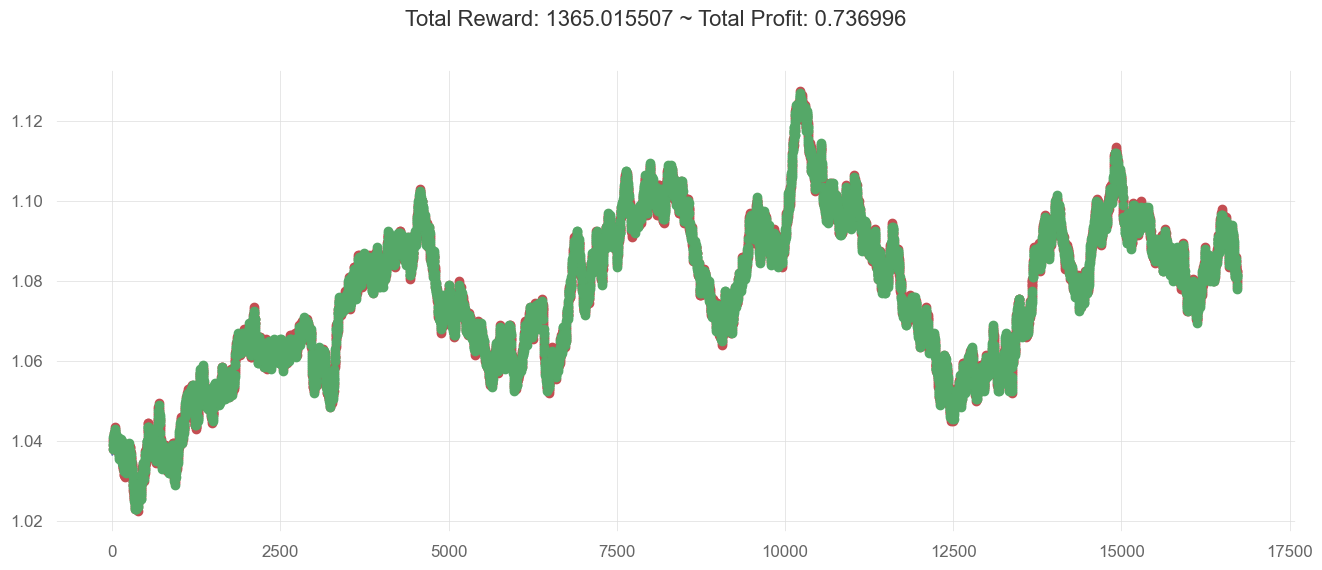

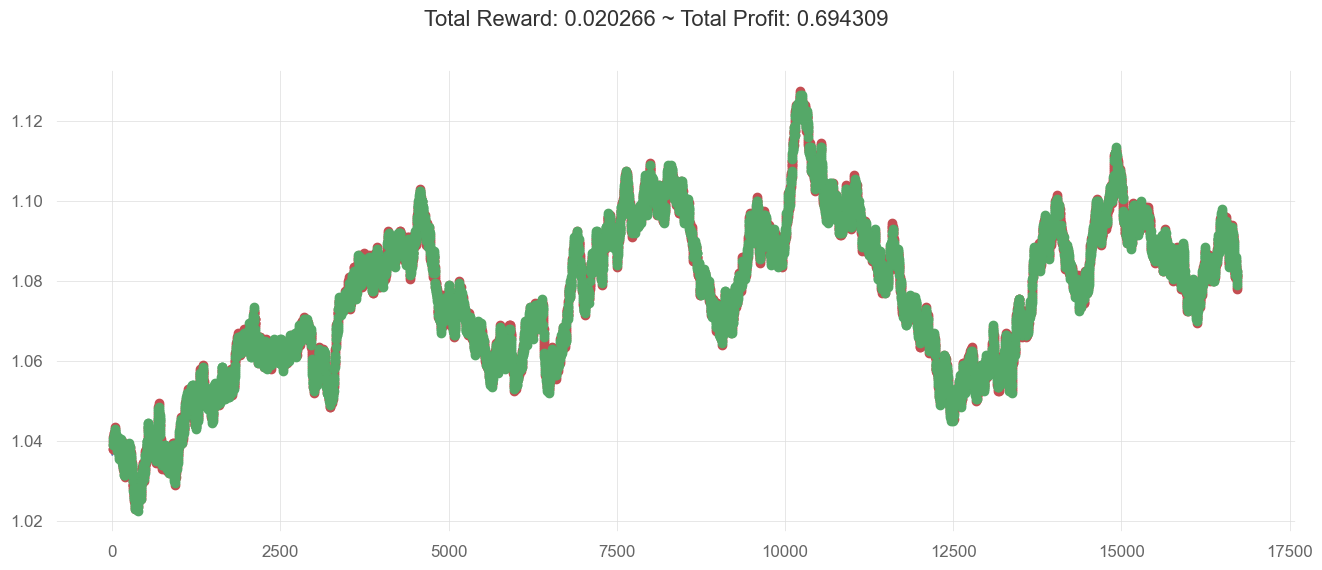

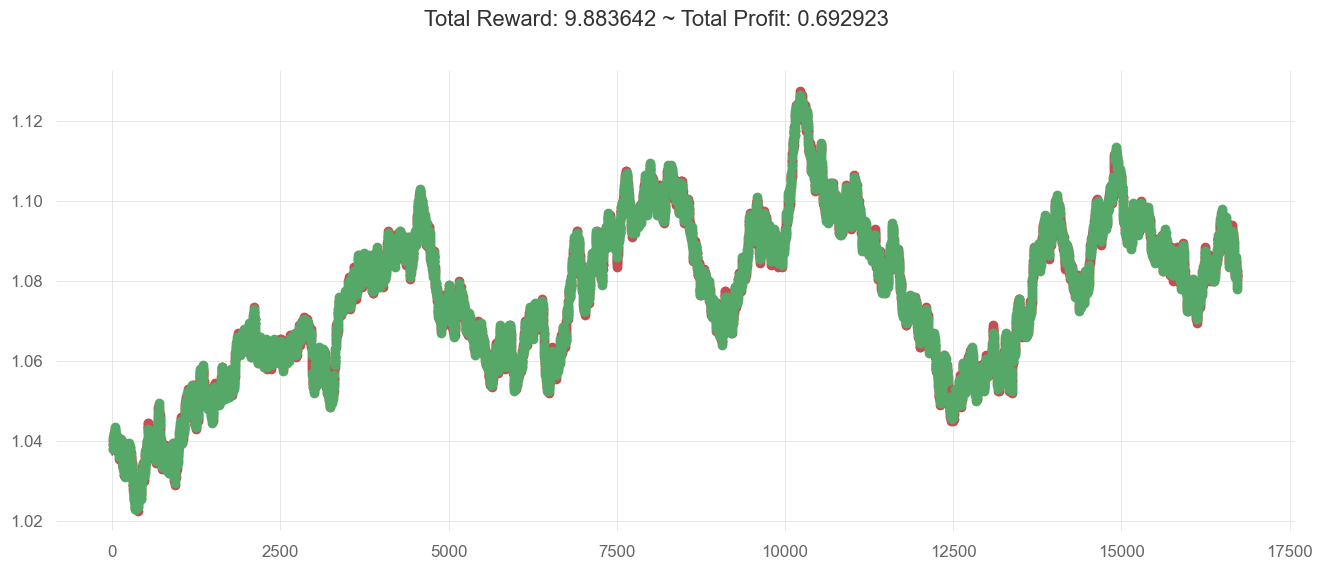

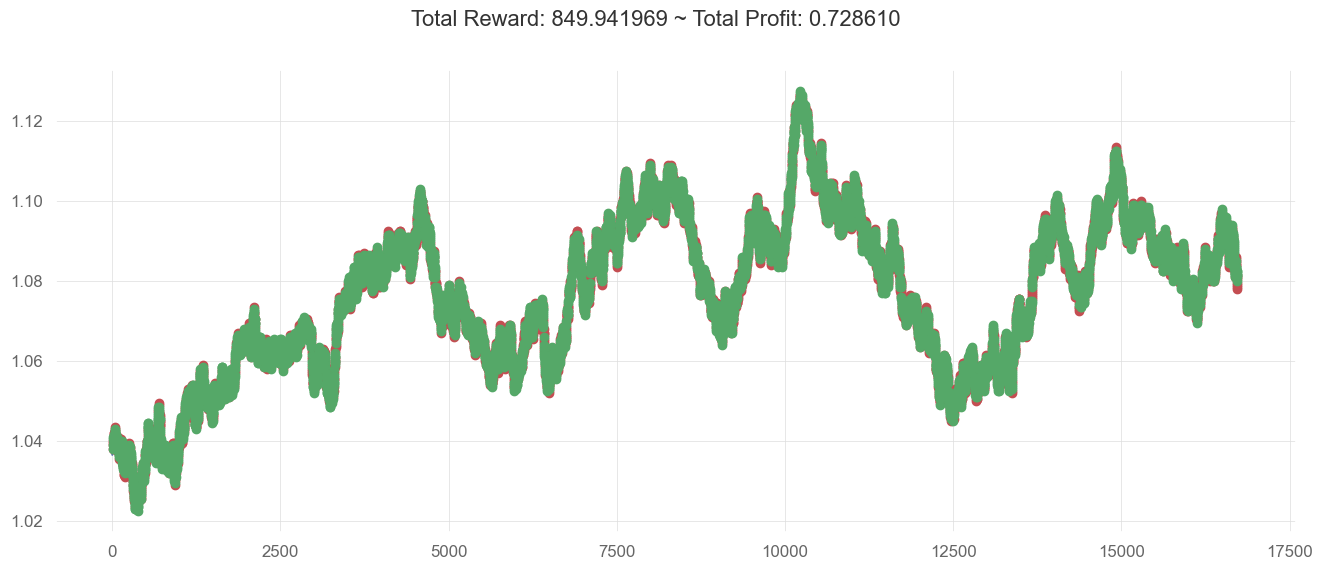

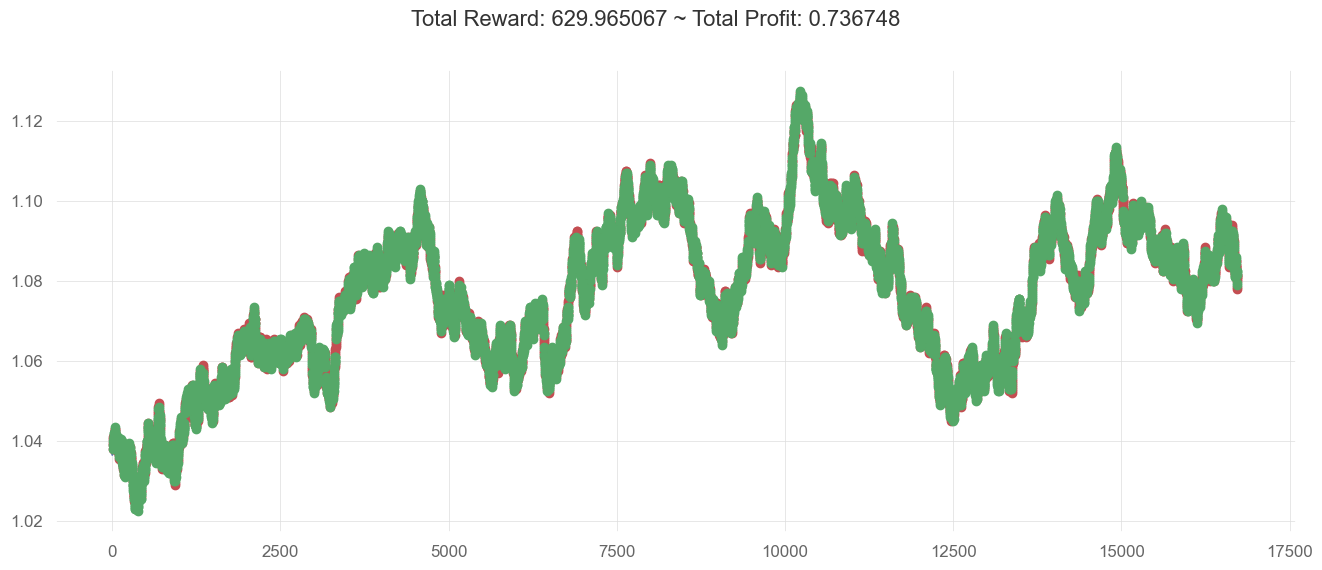

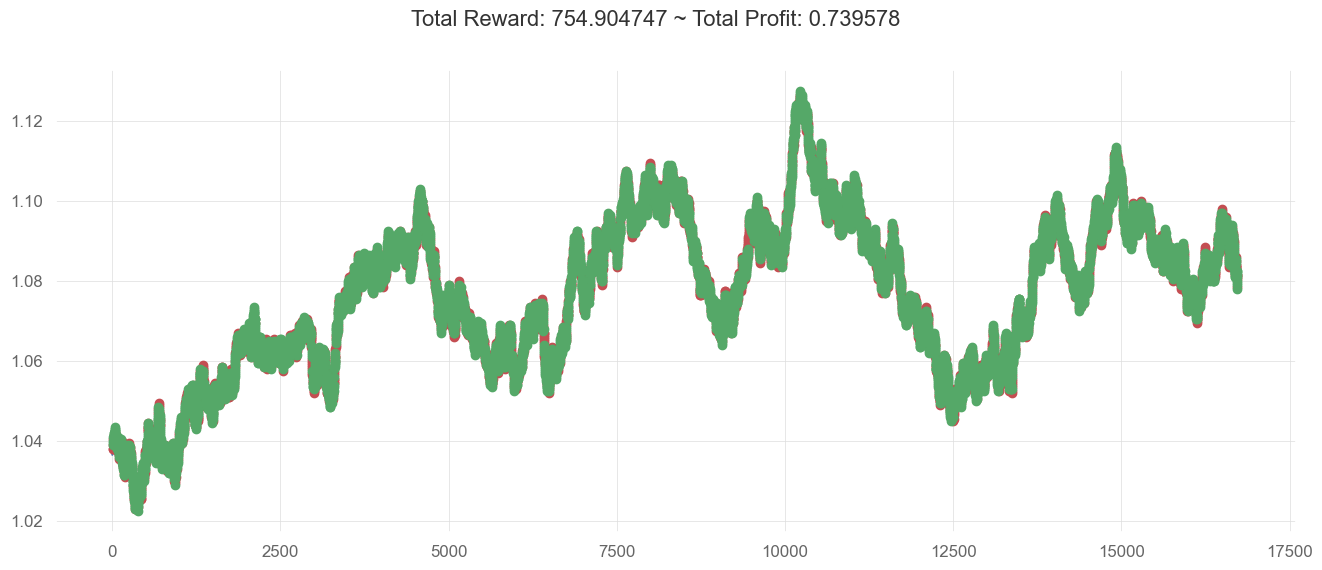

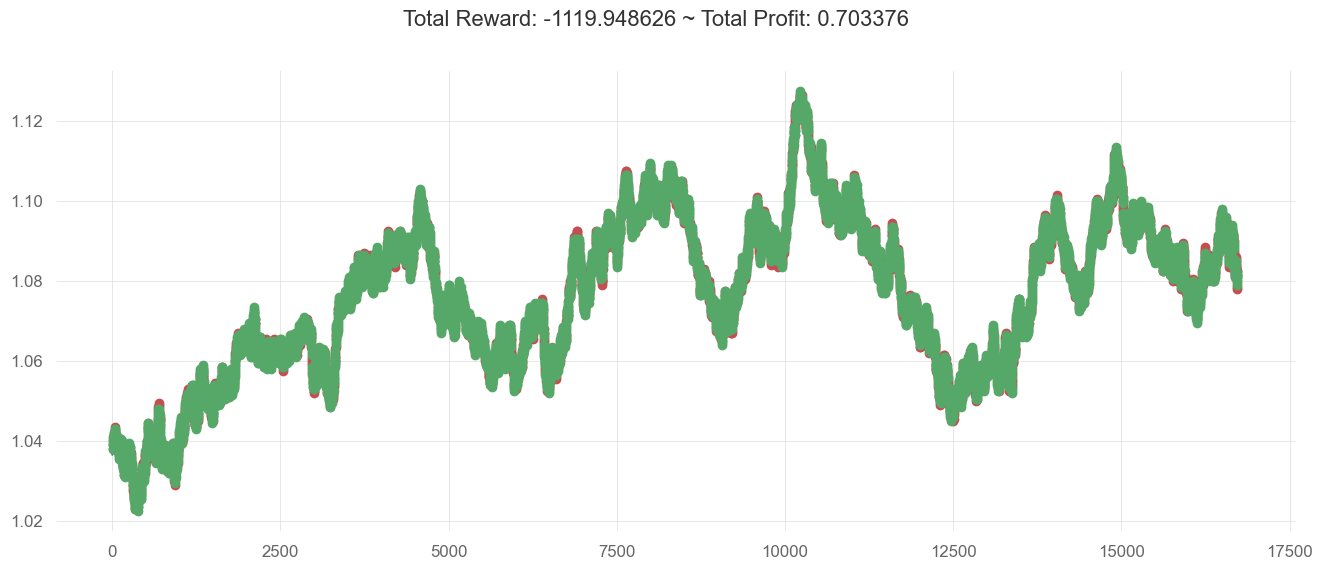

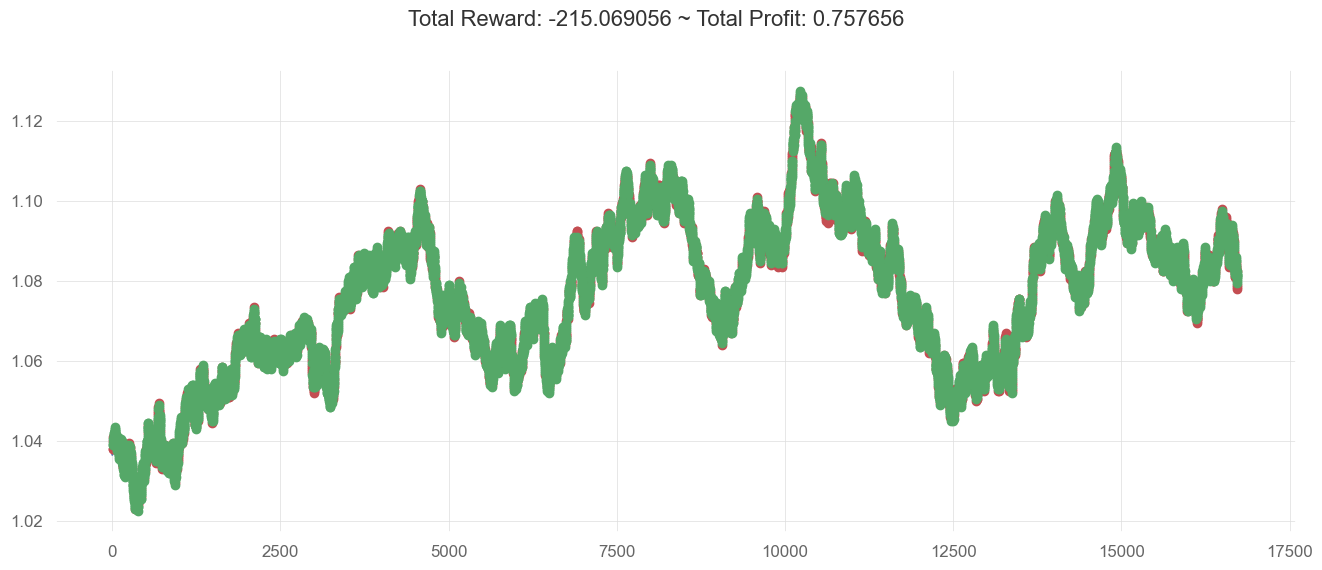

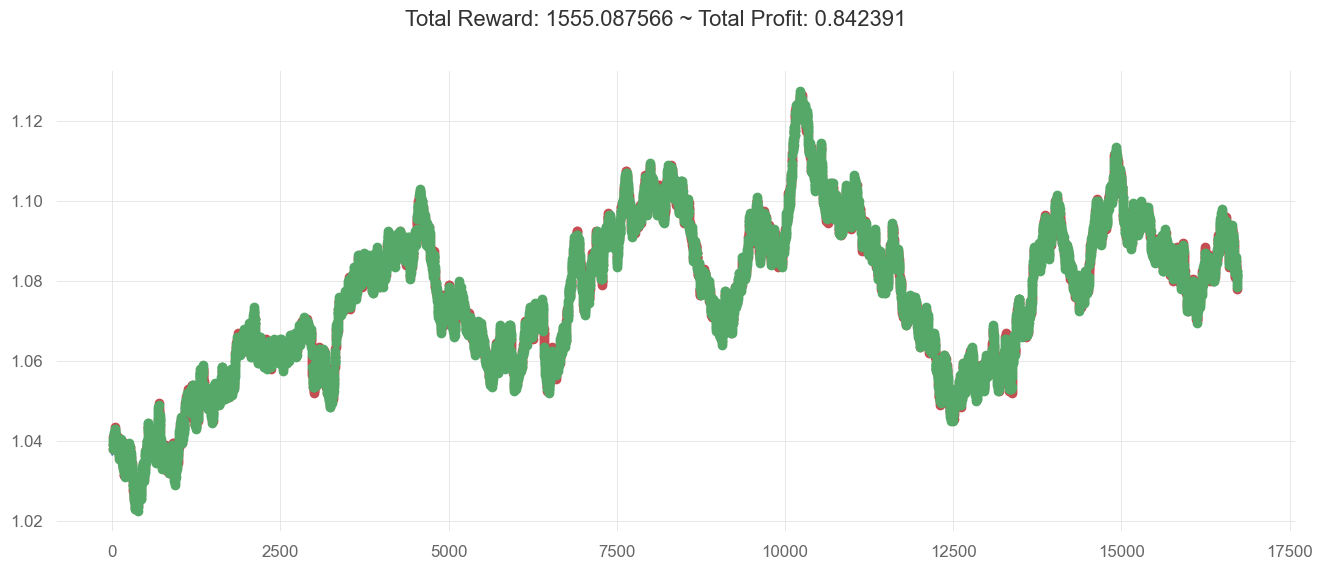

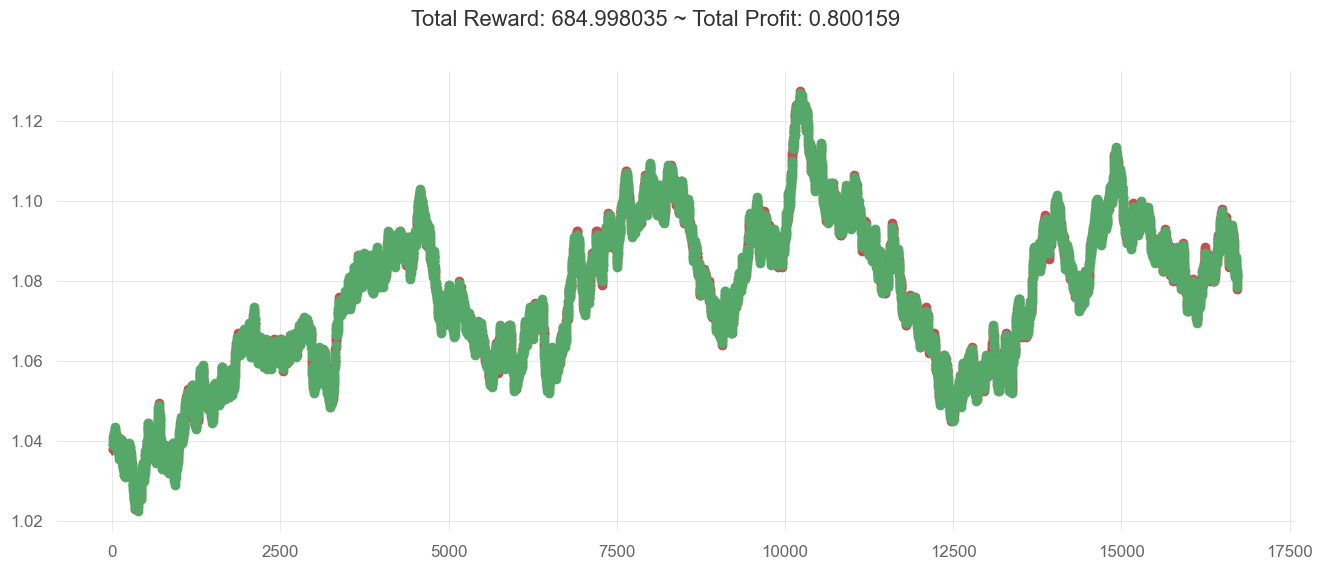

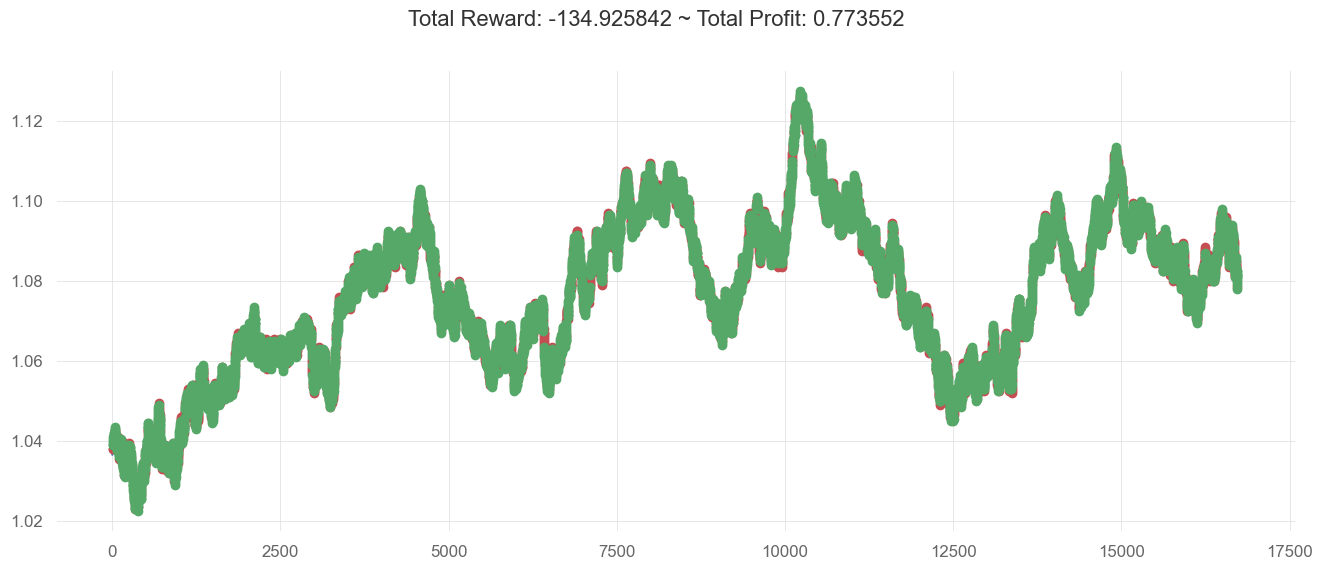

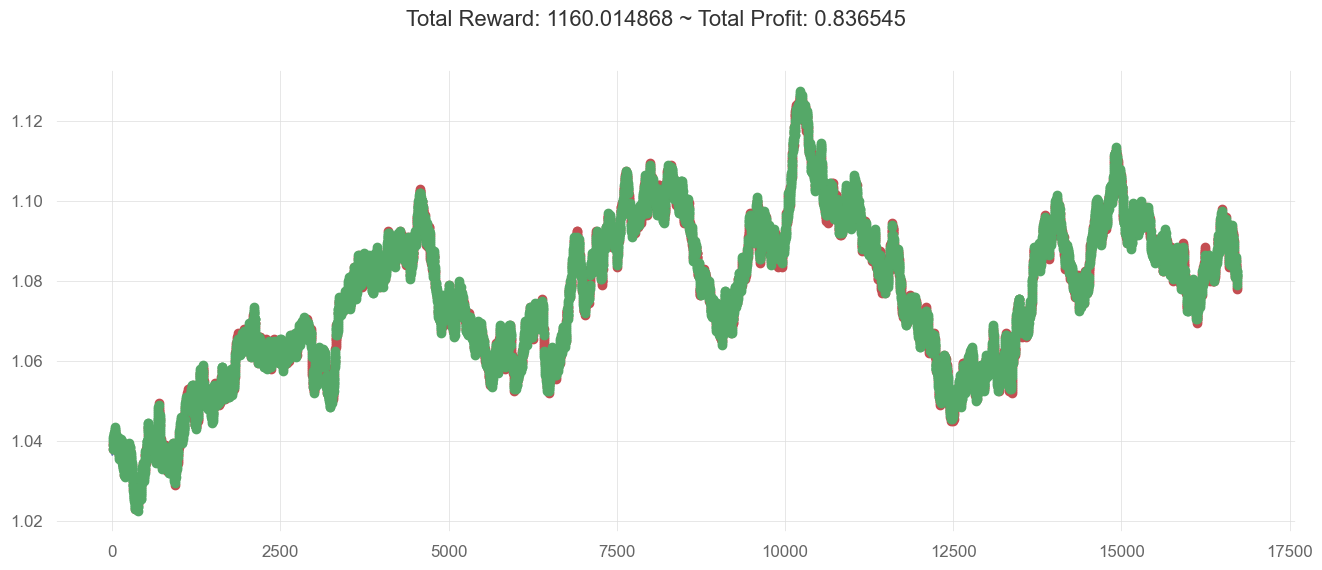

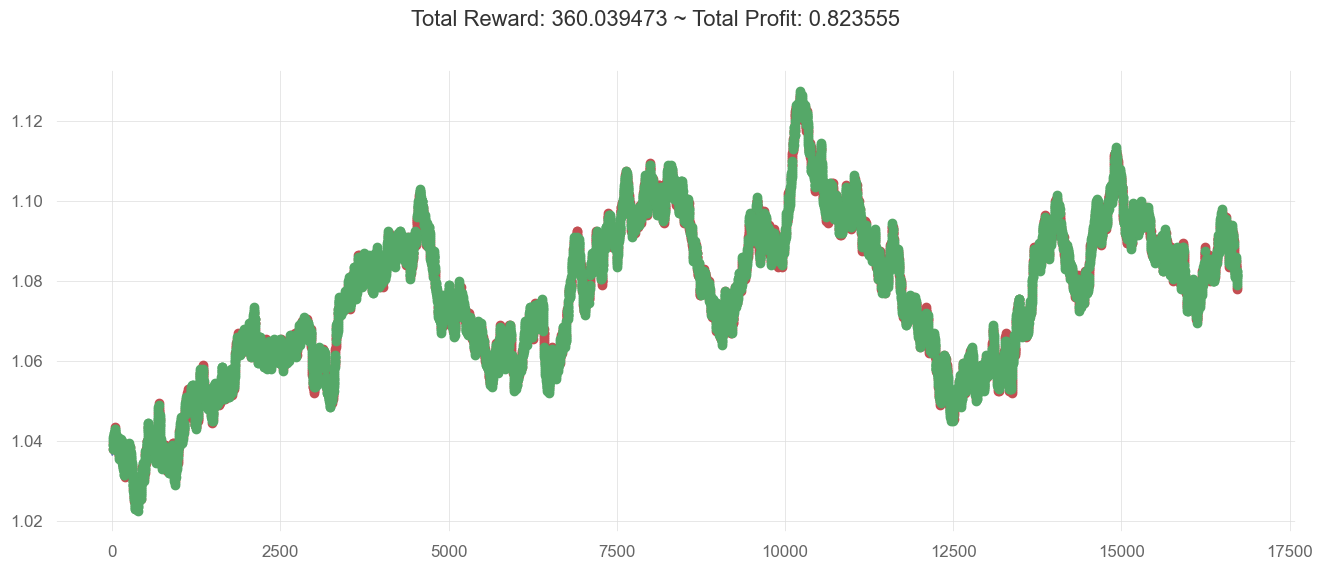

In [52]:
# Set the random seed
seed_ppo = 42
torch.manual_seed(seed_ppo)
random.seed(seed_ppo)
np.random.seed(seed_ppo)

total_learning_timesteps_ppo = 25 * 1000 # 5000
policy_dict_ppo = PPO.policy_aliases
policy_ppo = policy_dict_ppo.get('MlpPolicy')
if policy_ppo is None:
    policy_ppo = policy_dict_ppo.get('MlpLstmPolicy')

# Initialize the PPO model
model_ppo = PPO(policy_ppo, env_train, verbose=0, learning_rate=hyperparameters['lr'][0], gamma=hyperparameters['gamma'][0], ent_coef=hyperparameters['ent_coef'][0])

# Iterate through the training and testing sets
for i in range(0, len(FOREX_EURUSD_RENKO) - split, 10):
    action_stats = {Actions.Sell: 0, Actions.Buy: 0}
    # Update the training and testing environments
    env_train.frame_bound = (10, split + i)
    env_test.frame_bound = (split + i, len(FOREX_EURUSD_RENKO))

    # Train the model
    model_ppo.learn(total_timesteps=total_learning_timesteps_ppo // 10)
    # vec_env = model_ppo.get_env()

    # Evaluate the model on the testing set
    obs_test, info_test = env_test.reset()
    initial_shape = obs_test.shape
    done_test = False
    total_reward_test = 0
    j = 0
    while not done_test:
        j += 1
        action_test, _ = model_ppo.predict(obs_test)
        action_stats[Actions(action_test)] += 1
        obs_test, reward_test, terminated_test, truncated_test, info_test = env_test.step(action_test)
        if obs_test.shape != initial_shape:
            print(obs_test.shape, j, len(env_test.signal_features))
            terminated_test = True
        done_test = terminated_test or truncated_test
        total_reward_test += reward_test

    print(f"Iteration {i}: Testing Reward = {total_reward_test}")
    print(f"Iteration {i}: Actions = {action_stats}")
    print(f'Iteration {i}: info = {info_test}')
    plt.figure(figsize=(16, 6))
    env_test.unwrapped.render_all()
    plt.savefig(f"ppo_test_{i}.png")
    # plt.show()

# Save the model after training
model_ppo.save("ppo_model.pkl")

# Load the saved model
model_ppo = PPO.load("ppo_model.pkl", env=env_train)


In [37]:
len(env_train.signal_features) + len(env_test.signal_features), len(env_train.signal_features), len(env_test.signal_features), len(env_test.df)

(83713, 66988, 16725, 83703)

In [38]:
terminated_test or truncated_test

False

In [71]:
# env_test = MyForexEnv(
#     df=FOREX_EURUSD_RENKO,
#     window_size=10,
#     frame_bound=(start_index, end_index),
#     trade_fee=0.0001,
#     spread=0.0001,
#     spread_bool=False,
#     unit_side='right',
#     sma_length=4,
#     smoothing_sma=4
# )

# Random Actions

info: {'total_reward': -60.002803802490234, 'total_profit': 0.9875027290398094, 'position': <Positions.Long: 1>}


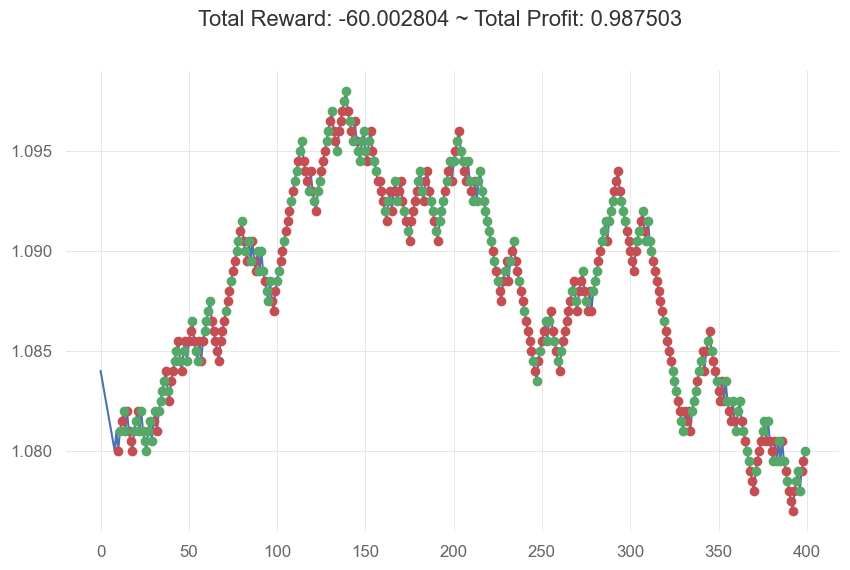

In [73]:
observation = env_test.reset(seed=seed_ppo)
action_stats_rdm = {Actions.Sell: 0, Actions.Buy: 0}
while True:
    action_rdm = env_test.action_space.sample()
    action_stats_rdm[Actions(action_rdm)] += 1
    observation, reward, terminated, truncated, info = env_test.step(action_rdm)
    done = terminated or truncated

    # env.render()
    if done:
        print("info:", info)
        print(f"action stats: {action_stats_rdm}")
        break

plt.cla()
env_test.unwrapped.render_all()
plt.show()

# Model Performance

In [74]:
# done = False
# action_stats = {Actions.Sell: 0, Actions.Buy: 0}
# test_obs, info_ppo = env_test.reset(seed=seed_ppo)
# rows = test_obs.shape[0]

# while not done:
#     if test_obs.shape[0] != rows:
#         # print(test_obs)
#         diff = rows - test_obs.shape[0]
#         test_obs = np.concatenate([test_obs, np.zeros((diff, test_obs.shape[1]))])
#         # print(test_obs.shape)    
#     action_ppo, _states = model_ppo.predict(test_obs)
#     action_stats[Actions(action_ppo)] += 1
#     test_obs, reward_ppo, terminated, truncated, info_ppo = env_test.step(action_ppo)
#     done = terminated or truncated

#     if done:
#         break

# env_test.close()

# print("action_stats:", action_stats)
# print("info:", info_ppo)

action_stats: {<Actions.Sell: 0>: 363, <Actions.Buy: 1>: 26}
info: {'total_reward': 90.00062942504883, 'total_profit': 1.001773462105597, 'position': <Positions.Long: 1>}


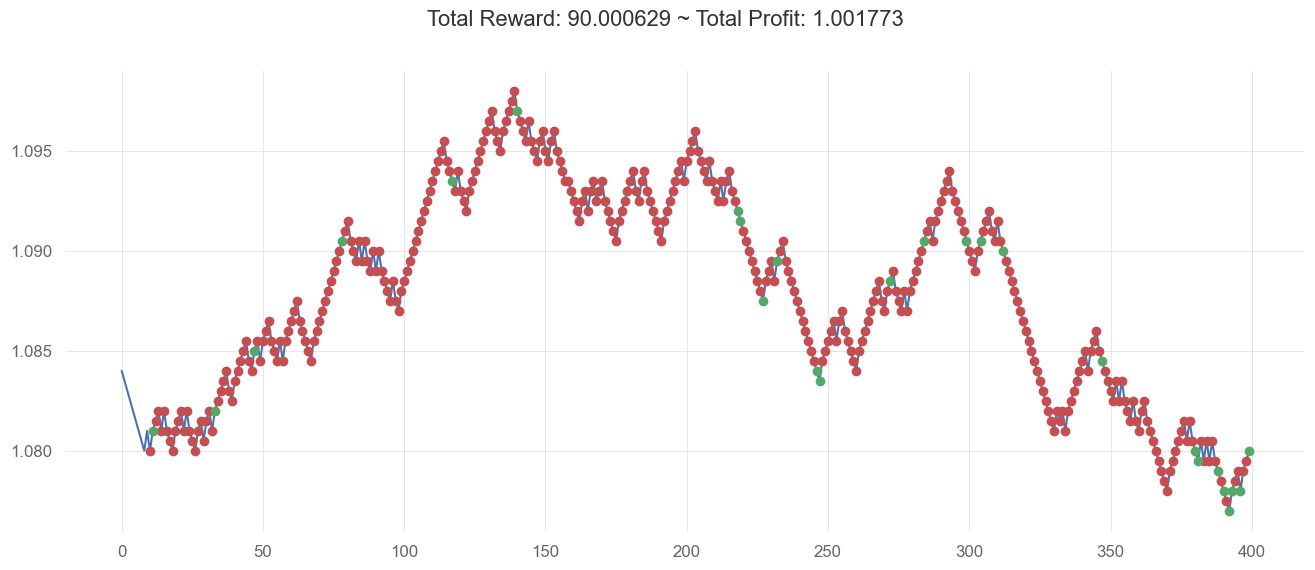

In [75]:
# plt.figure(figsize=(16, 6))
# env_test.unwrapped.render_all()
# plt.show()

In [76]:
# qs.extend_pandas()
# window_size = 10


# net_worth = pd.Series(env_test.unwrapped.history['total_profit'], index=FOREX_EURUSD_RENKO.index[start_index+1:end_index])
# returns = net_worth.pct_change().iloc[1:]

# qs.reports.full(returns)
# qs.reports.html(returns, output='SB3_a2c_quantstats_ppo_Billy.html')

ValueError: Length of values (389) does not match length of index (392)